# EDA Prelim results
- Removing Region 1, Tester name, and Taster twitter handle.
- Removing rows with null entries in the description, designation, variety, winery, title.
- A large share wines in the dataset comes from the US (especially California).
- Some popular grape types are Pinor Noir, Chardonnay, Red Blend, Cabernet Sauvignon.

- Most wines in our data has only 1 review --> potential bias if we want to use these reviews to predict the exact wine.

    - 91% of wine titles has only 1 review - these reviews make up 83% of review data
    
    - 60% of wine designations has only 1 review - these reviews make up 75% of review data

- In case we use the Classification approach, check if a wine style has sufficient number of reviews. I consider 2 defitions for style: *province-variety* and *province-variety-winery* combinations. 

    - *province-variety* seems to be a better definition, because most styles defined as such has at least 80 reviews. If we discards all style with < 80 reviews, we retain 80% of review data. This yields 228 styles, with a mean review counts for each style being 455 reviews.
    
        - pie chart of styles with at least 80 reviews shows that no style dominates the sample .
        
    - *province-variety-winery* result in style groups that are too grnular - max count per style is 140, min count is much smaller.

- Check some meta features of the reviews to ensure they are not to short or too long to be chopped off by the transformer algorithms. Everything checks out: length of the reviews are not too long or too short.

- Visualize some most common words: 'flavor', 'fruit', 'finish', 'palate', 'acidity'

## Data cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string 
import re
import spacy

To read csv file in a different directory - Copied the path by the *copy path* option in the right click of that file. Replace forward slash \ with / or \\ or (r"C:\... path of the file")

In [2]:
wine = pd.read_csv('../Data/Raw Data/winemag-data-130k-v2.csv', encoding='utf-8')
wine.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
wine.head(10)

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


### Remove Unnecessary Columns

Removing Region 1, Tester name, and Taster twitter handle.

In [3]:
wine.drop(['region_2','taster_name','taster_twitter_handle'], axis=1, inplace = True)

In [4]:
wine.head()

,id,country,description,designation,points,price,province,region_1,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Removing Rows with NaN entries

Removing rows with null entries in the description, designation, variety, winery, title.

 The *dropna()* method removes all rows that contain null values in the specified column.


In [5]:
wine.dropna(subset=['description','designation','title','variety','winery'], inplace=True)

In [6]:
wine.head(10)

,id,country,description,designation,points,price,province,region_1,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
13,13,Italy,This is dominated by oak and oak-driven aromas...,Rosso,87,NaN,Sicily & Sardinia,Etna,Masseria Setteporte 2012 Rosso (Etna),Nerello Mascalese,Masseria Setteporte


### Combining Columns - Province, Region 1

Comning Province, Region 1 columns to replace null entries in either of the columns! 

Combining columns in pandas using the *.apply()* method. This method allows you to apply a custom function to each row or column of a DataFrame, which can be useful for more complex data manipulation tasks.

In [7]:
# For now filling in the null values with *no region* and *no province*
# Later as we need I will remove it completely but just in case if we need
# to discriminate between region/province wrt a county!

wine['region_1'].fillna("No Region", inplace = True)
wine['province'].fillna("No Province", inplace = True)


# Define a custom function to combine columns
def combine_columns(row):
    return str(str(row['region_1']) + ', ' + str(row['province']))

# Apply the custom function to create a new column 'Region'
wine['Region'] = wine.apply(combine_columns, axis=1)

In [8]:
wine.head()

,id,country,description,designation,points,price,province,region_1,title,variety,winery,Region
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"Etna, Sicily & Sardinia"
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,No Region,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"No Region, Douro"
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"Lake Michigan Shore, Michigan"
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"Willamette Valley, Oregon"
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,"Navarra, Northern Spain"


Another method: Using agg() method to Concat String Columns of DataFrame

For ex.:

import pandas as pd

Create a sample DataFrame
data = {'Column1': [1, 2, 3],
        'Column2': ['A', 'B', 'C']}

df = pd.DataFrame(data)

df["Column1"] = df["Column1"].astype(str)

 Apply the custom function to create a new column 'Combined'
df['Combined'] = df[['Column1', 'Column2']].agg(''.join, axis=1)

In [9]:
# filling in the null values in price column with 'Price not avaible'

wine['price'].fillna("Price not avaible", inplace = True)

C:\Users\ngocn\AppData\Local\Temp\ipykernel_25356\163460511.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Price not avaible' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  wine['price'].fillna("Price not avaible", inplace = True)


In [10]:
wine.head()

,id,country,description,designation,points,price,province,region_1,title,variety,winery,Region
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,Price not avaible,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"Etna, Sicily & Sardinia"
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,No Region,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"No Region, Douro"
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"Lake Michigan Shore, Michigan"
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"Willamette Valley, Oregon"
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,"Navarra, Northern Spain"


In [11]:
wine['title'].isnull().values.any()

False

In [12]:
#Or,
wine['title'].isnull().sum()

0

Now we want to make sure we have enough reviews per wine variety!

In [13]:
wine['title'].value_counts()

title
Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)                         11
Korbel NV Brut Sparkling (California)                                           9
Segura Viudas NV Extra Dry Sparkling (Cava)                                     8
Gloria Ferrer NV Blanc de Noirs Sparkling (Carneros)                            7
Ruinart NV Brut Rosé  (Champagne)                                               7
                                                                               ..
Santa Barbara Winery 2011 Rosé of Syrah (Sta. Rita Hills)                       1
Cadence 2006 Cara Mia Vineyard Camerata Red Wine Red (Red Mountain)             1
Chaleur Estate 2007 Blanc White (Columbia Valley (WA))                          1
Williams Selyem 2006 Bucher Vineyard Pinot Noir (Russian River Valley)          1
Domaine Schoffit 2012 Lieu-dit Harth Cuvée Caroline Gewurztraminer (Alsace)     1
Name: count, Length: 84551, dtype: int64

In [14]:
wine['variety'].value_counts()

variety
Pinot Noir                  9893
Chardonnay                  7843
Red Blend                   7457
Cabernet Sauvignon          5801
Riesling                    4394
                            ... 
Gragnano                       1
Grolleau                       1
Pinot Blanc-Pinot Noir         1
Nielluciu                      1
Bobal-Cabernet Sauvignon       1
Name: count, Length: 644, dtype: int64

In [15]:
# wine['variety'].value_counts().any()

In [16]:

# if (wine['variety'].value_counts() < 100):
#     print('{} : {}'.format(wine['variety'].tolist(), wine['variety'].value_counts()))

# Visualization

## Check distribution of countries

First, let's look at the **distribution of countries** with the help of pie-chart.

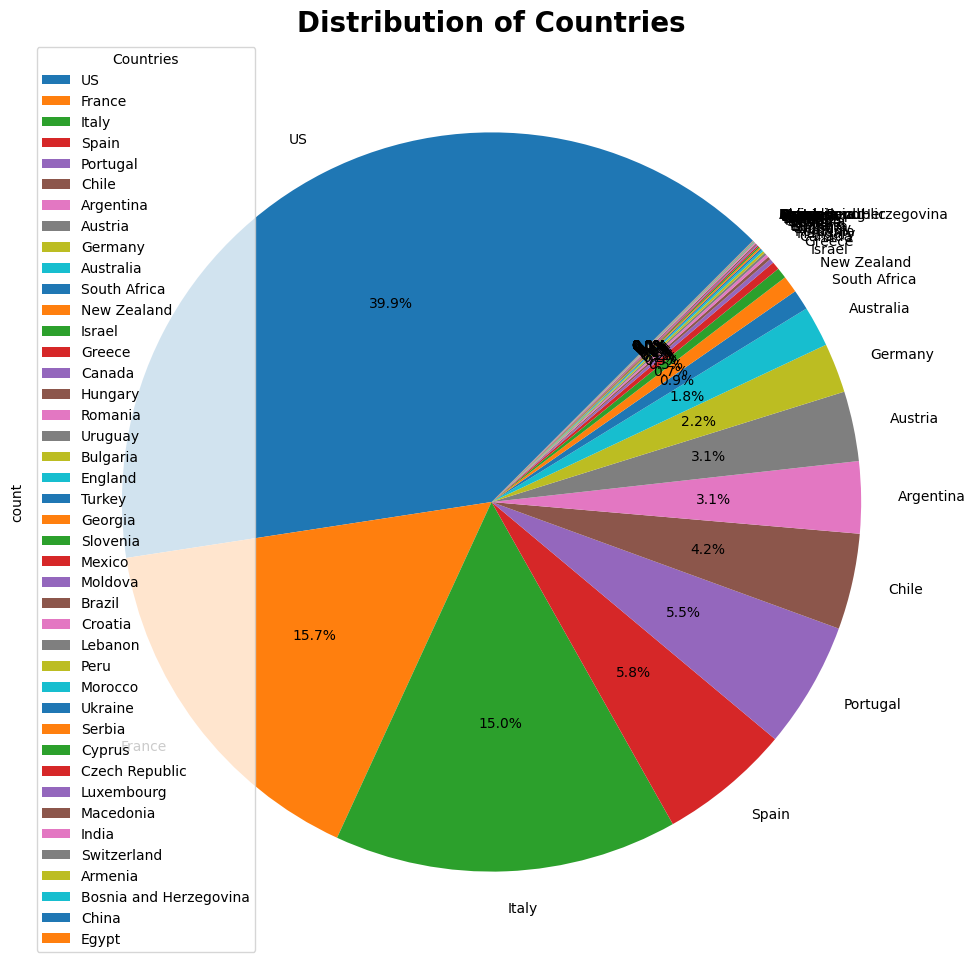

In [17]:
fig = plt.figure(figsize=(12,12))
number_countries = wine['country'].value_counts()
number_countries.plot(kind = 'pie', autopct = '%0.1f%%', startangle = 45)
plt.legend(title="Countries")
plt.title("Distribution of Countries", fontsize ='20', fontweight = 'bold')
plt.show()

## Check distribution of variety (grape type)

Now, let's look at the **Distribution of variety (grape type)**

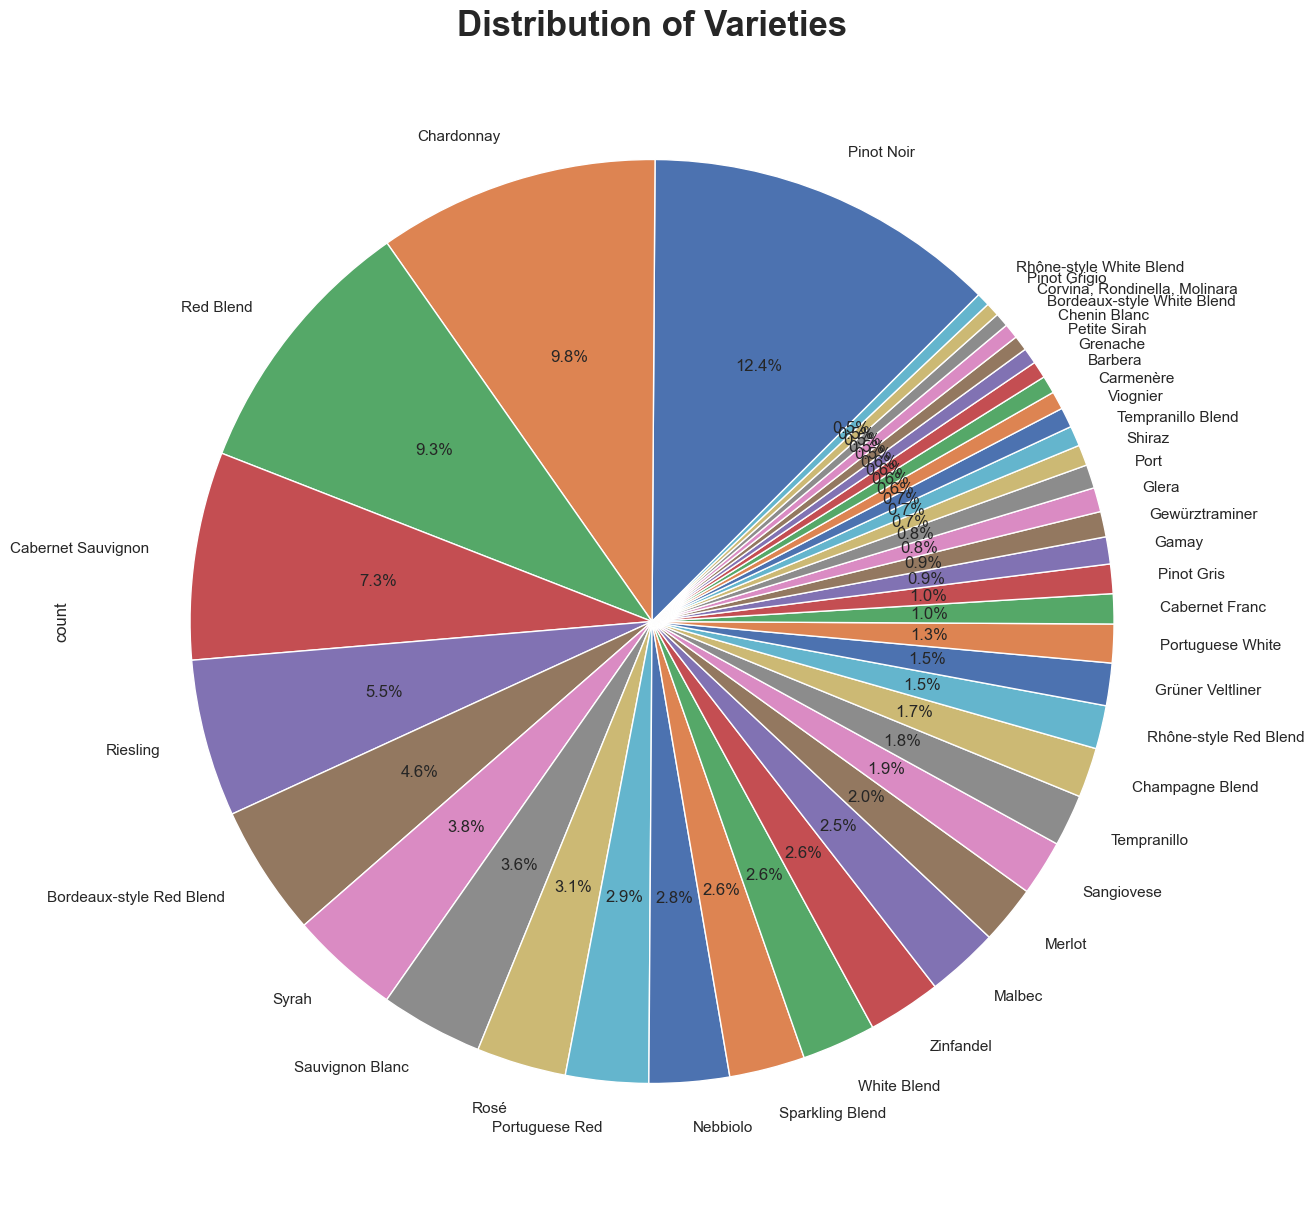

In [52]:
fig = plt.figure(figsize=(15,15))
number_countries = wine['variety'].value_counts()[:40]
number_countries.plot(kind = 'pie', autopct = '%0.1f%%', startangle = 45)
# plt.legend(title="Varieties")
plt.title("Distribution of Varieties", fontsize ='25', fontweight = 'bold')
plt.show()

## Check distribution of province

Finally, **Distribution of Province** 

In [19]:
province = wine['province'].value_counts()
province

province
California                 24359
Washington                  5892
Oregon                      3789
Tuscany                     3728
Northern Spain              3077
                           ...  
Vinho da Mesa                  1
Coelemu                        1
Beotia                         1
Piekenierskloof                1
Vin de Pays de Velvendo        1
Name: count, Length: 407, dtype: int64

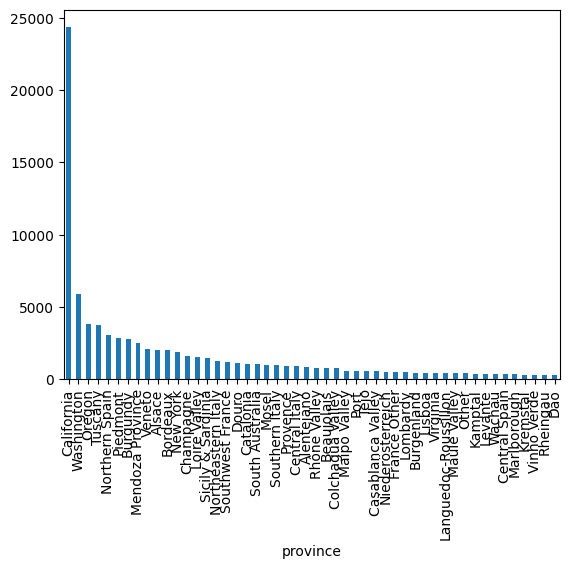

In [20]:
wine['province'].value_counts()[:50].plot(kind = 'bar')
plt.show()

## Check wine *style* definition

In [21]:
wine['style'] = wine['variety'] + ' - ' + wine['province']
wine['style2'] = wine['variety'] + ' - ' + wine['province'] + ' - ' + wine['winery']

In [22]:
# Define bar_chart_top20 function with seaborn styling
def bar_chart_top20(data, var_name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,4))
    sns.countplot(y = var_name, 
                  data = data,
                  order = data[var_name].value_counts(ascending=False).index[1:20]) 
    plt.title(f'Number of reviews per {var_name}') 
    plt.show()
    return 

# Define bar_chart_top50 function with seaborn styling
def bar_chart_top50(data, var_name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,10))
    sns.countplot(y = var_name, 
                  data = data,
                  order = data[var_name].value_counts(ascending=False).index[1:50]) 
    plt.title(f'Number of reviews per {var_name}') 
    plt.show()
    return 

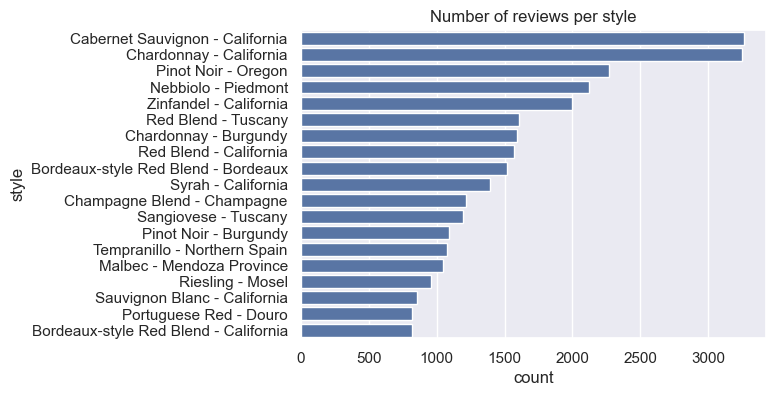

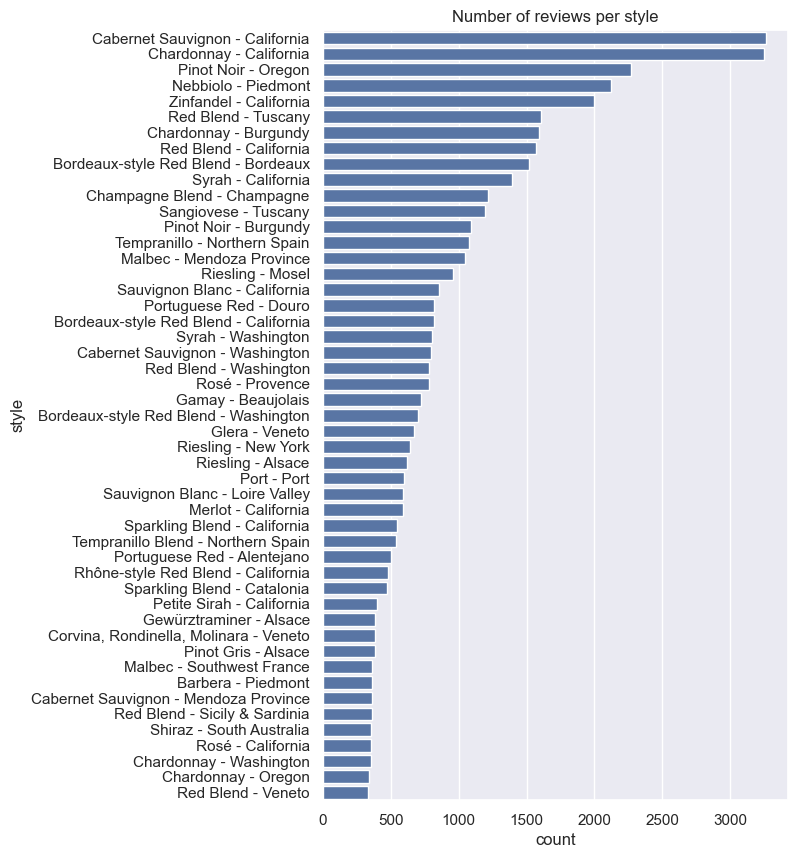

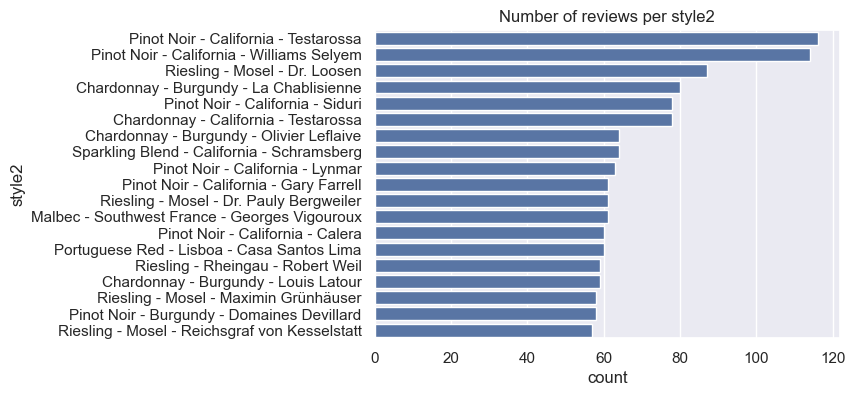

In [23]:
bar_chart_top20(wine, 'style') 
bar_chart_top50(wine, 'style') # 'style' is better than 'style2'
bar_chart_top20(wine, 'style2') ## too fine, many categories will have too few reviews

In [24]:
# Check how much of the sample is left if drop wine style with less than 80 reviews --> 80% of sample
tab_by_style = wine.groupby('style')['id'].count().reset_index()
tab_by_style.rename(columns={'id':'count'}, inplace=True)
tab_by_style.sort_values('count', ascending=False, inplace=True)
tab_by_style['tot_count'] = tab_by_style['count'].sum()
tab_by_style['share'] = tab_by_style['count']/tab_by_style['tot_count']
tab_by_style['share_cum'] = tab_by_style['share'].cumsum()

display(tab_by_style[tab_by_style['count']>=80].tail())
print('Mean review count per style =', tab_by_style[tab_by_style['count']>=80]['count'].mean())


,style,count,tot_count,share,share_cum
1112,Grenache - Washington,81,92506,0.000876,0.757183
1162,Grüner Veltliner - Weinviertel,81,92506,0.000876,0.758059
1394,Merlot - New York,81,92506,0.000876,0.758935
2461,Rosé - France Other,80,92506,0.000865,0.759799
3022,Syrah - Tuscany,80,92506,0.000865,0.760664


Mean review count per style = 388.76243093922653


In [25]:
print('Style = province x variety, number of classes =', len(wine['style'].unique()))
print('Style = province x variety x winery, number of classes =',len(wine['style2'].unique()))

print('Style = province x variety, number of classes if drop classes <80 reviews =',len(tab_by_style[tab_by_style['count']>=80]))

Style = province x variety, number of classes = 3601
Style = province x variety x winery, number of classes = 32190
Style = province x variety, number of classes if drop classes <80 reviews = 181


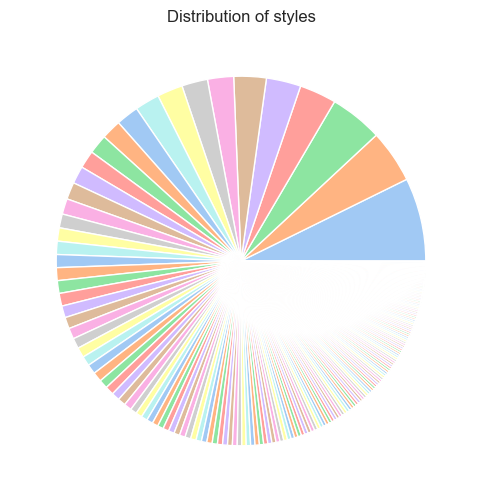

In [26]:
# Define pie_chart function with seaborn styling
def pie_chart(data, var_name, name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,6))
    colors = sns.color_palette("pastel", n_colors=len(data))
    plt.pie(data=data, x=var_name, colors=colors)
    plt.title(f'Distribution of {name}') 
    plt.show()
    return 


# Check the relative size of each class (style)
pie_chart(tab_by_style[tab_by_style['count']>=80], 'count', 'styles')


In [27]:
# Check how many wine titles have only 1 reviews --> 83% of reviews describe 1 unique wine title
tab_by_title = wine.groupby('title')['id'].count().reset_index()
tab_by_title.rename(columns={'id':'count'}, inplace=True)
tab_by_title.sort_values('count', ascending=False, inplace=True)
tab_by_title['tot_count'] = tab_by_title['count'].sum()
tab_by_title['share'] = tab_by_title['count']/tab_by_title['tot_count']
tab_by_title['share_cum'] = tab_by_title['share'].cumsum()

display(tab_by_title[tab_by_title['count']>1].tail()) # 1-0.16824 = 0.83176

,title,count,tot_count,share,share_cum
79490,Vilarnau NV Reserva Brut Rosé Sparkling (Cava),2,92506,0.000022,0.168184
79309,Vignerons des Terres Secrètes 2014 Les Plantés...,2,92506,0.000022,0.168205
48734,Louis Latour 2012 Vignes Franches Premier Cru ...,2,92506,0.000022,0.168227
43983,Kintonis 2015 M Malagousia (Peloponnese),2,92506,0.000022,0.168249
128,6 North 2009 Flagstone Cabernet Sauvignon (Nap...,2,92506,0.000022,0.168270


In [28]:
print('Share of wine titles with at least 2 reviews:', len(tab_by_title[tab_by_title['count']>=2])/len(tab_by_title))
print('Share of wine titles with at least 5 reviews:', len(tab_by_title[tab_by_title['count']>=5])/len(tab_by_title))

Share of wine titles with at least 2 reviews: 0.09001667632553134
Share of wine titles with at least 5 reviews: 0.0003666426180648366


In [29]:
# Check how many wine designations have only 1 review --> 25% of reviews describe 1 unique wine designation
# Check how many wine designations have less than 5 reviews --> 65% of reviews describe 1 unique wine designation
tab_by_desig = wine.groupby('designation')['id'].count().reset_index()
tab_by_desig.rename(columns={'id':'count'}, inplace=True)
tab_by_desig.sort_values('count', ascending=False, inplace=True)
tab_by_desig['tot_count'] = tab_by_desig['count'].sum()
tab_by_desig['share'] = tab_by_desig['count']/tab_by_desig['tot_count']
tab_by_desig['share_cum'] = tab_by_desig['share'].cumsum()

display(tab_by_desig[tab_by_desig['count']>5].tail()) # 1-0.368171 = 0.631829
display(tab_by_desig[tab_by_desig['count']>2].tail()) # 1-0.591583 = 0.408417
display(tab_by_desig[tab_by_desig['count']>1].tail()) # 1-0.753065 = 0.2469

,designation,count,tot_count,share,share_cum
22582,Monte Cascas Grande Reserva,6,92506,0.000065,0.367911
24488,Oscar's Branco,6,92506,0.000065,0.367976
21942,Memorias,6,92506,0.000065,0.368041
195,20 Barrels,6,92506,0.000065,0.368106
1182,Altenberg,6,92506,0.000065,0.368171


,designation,count,tot_count,share,share_cum
31708,Split Oak Estates Sur Lie,3,92506,0.000032,0.591454
1382,Ami's Vineyard,3,92506,0.000032,0.591486
18845,Le Bouissel,3,92506,0.000032,0.591518
4426,Brosseau,3,92506,0.000032,0.591551
31644,Special Select,3,92506,0.000032,0.591583


,designation,count,tot_count,share,share_cum
10905,Dry Unfiltered Rkatsiteli Mtsvane,2,92506,0.000022,0.752978
10152,Dollarhide Elevation,2,92506,0.000022,0.753000
10418,Domaine de la Moutonnière,2,92506,0.000022,0.753021
11311,Eighteen Seventy-Three,2,92506,0.000022,0.753043
37933,Éclat Vigno Old Vine Dry-Farmed,2,92506,0.000022,0.753065


In [30]:
print('Share of wine designations with at least 2 reviews:', len(tab_by_desig[tab_by_desig['count']>=2])/len(tab_by_desig))
print('Share of wine designations with at least 5 reviews:', len(tab_by_desig[tab_by_desig['count']>=5])/len(tab_by_desig))

Share of wine designations with at least 2 reviews: 0.3985360330709076
Share of wine designations with at least 5 reviews: 0.07809578977856184


## Check meta features of reviews

**word count**, unique word count, stop word count, mean word length ,character count, punctuation count

In [31]:
from spacy.lang.en.stop_words import STOP_WORDS

In [32]:
word_count = [ len(r.split()) for r in wine['description'] ]
unique_word_count = wine['description'].apply(lambda x: len(set(x.split())))
#  [ len(set(r.split())) for r in wine['description']] 
stop_word_count = wine['description'].apply(lambda x: len(set(x.split()) & STOP_WORDS))
mean_word_length = wine['description'].apply(lambda x: sum(map(len, x.split()))/len(x.split()) )
character_count = wine['description'].apply(lambda x: len(x.replace(' ',''))) # exclusing space
punctuation_count = wine['description'].apply(lambda x: len(re.findall(f'[{string.punctuation}]', x)))

In [33]:
meta_list = [word_count, 
             unique_word_count,
             stop_word_count, 
             mean_word_length,
             character_count, 
             punctuation_count]
meta_features = pd.DataFrame(meta_list).T
meta_features.columns = ['word_count', 
                         'unique_word_count',
                         'stop_word_count', 
                         'mean_word_length',
                         'character_count', 
                         'punctuation_count']

In [34]:
# Check min and max word counts
print('min word count = ', meta_features.word_count.min())
print('max word count = ', meta_features.word_count.max())

min word count =  3.0
max word count =  135.0


In [35]:
# Define histogram function with seaborn styling
def hist_plot(data, var_name):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,4))
    sns.histplot(data=data, x=var_name)
    plt.title(f'Histogram of {var_name}') 
    plt.show()
    return ax

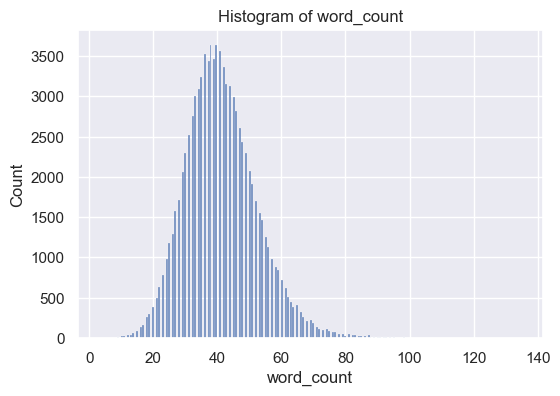

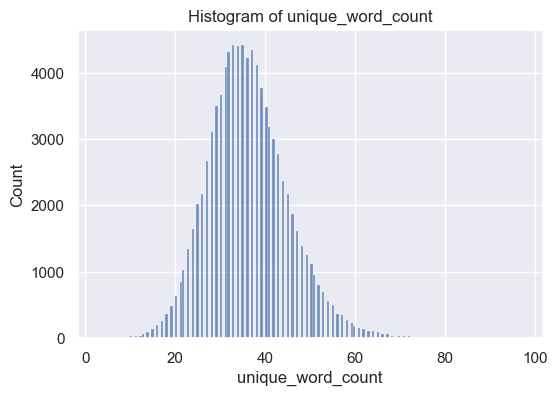

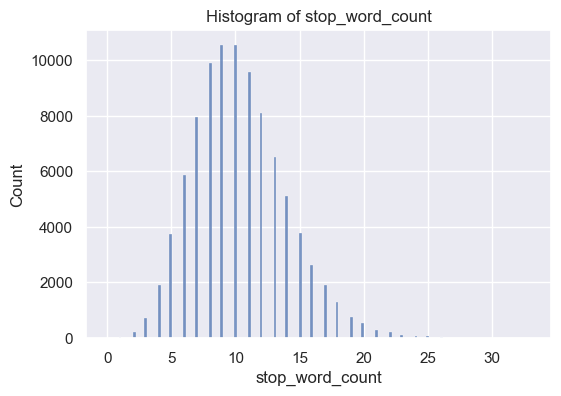

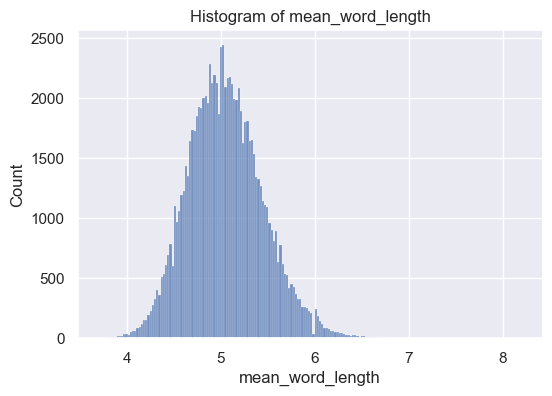

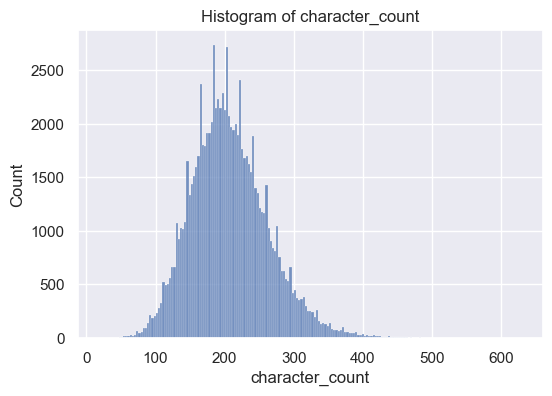

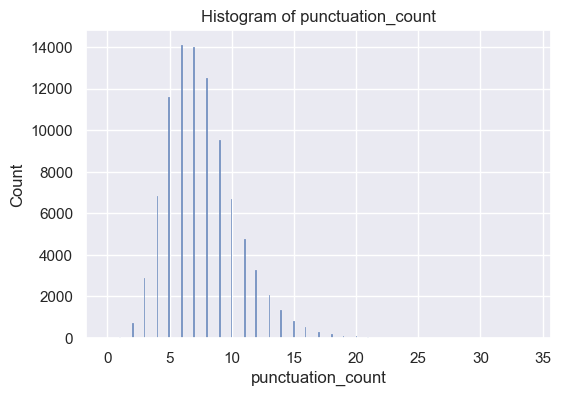

In [36]:
for f in meta_features:
    hist_plot(meta_features, f)

## Polular N-grams

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load("en_core_web_sm")


In [45]:
to_remove = [c for c in string.punctuation]
to_remove.append('wine')

In [46]:
# Unigrams
def tokenize_lemma(text):
    return [w.lemma_.lower() for w in nlp(text)]

stop_words_lemma = list(tokenize_lemma(' '.join(STOP_WORDS)))

unigr_counter = CountVectorizer(max_features=50, 
                                tokenizer = tokenize_lemma,
                                stop_words = stop_words_lemma) 

wine_1gram = unigr_counter.fit_transform(wine['description'] )
wine_1gram_df = pd.DataFrame(wine_1gram.toarray(), columns=unigr_counter.get_feature_names_out())

# remove punctuation characters + the word 'wine' since it's not helpful
wine_1gram_df = wine_1gram_df.loc[:, ~wine_1gram_df.columns.isin(to_remove)] 

In [47]:
# Bigrams
bigr_counter = CountVectorizer(max_features=50, 
                             ngram_range=(2,2), 
                             stop_words=list(STOP_WORDS) )

wine_2gram = bigr_counter.fit_transform( wine['description']  )
wine_2gram_df = pd.DataFrame(wine_2gram.toarray(), columns=bigr_counter.get_feature_names_out())

# remove punctuation characters
wine_2gram_df = wine_2gram_df.loc[:, ~wine_2gram_df.columns.isin(set(to_remove))] 

C:\Users\ngocn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [48]:
# Trigrams
trigr_counter = CountVectorizer(max_features=50, 
                             ngram_range=(3,3), 
                             stop_words=list(STOP_WORDS) )

wine_3gram = trigr_counter.fit_transform( wine['description']  )
wine_3gram_df = pd.DataFrame(wine_3gram.toarray(), columns=trigr_counter.get_feature_names_out())

# remove punctuation characters
wine_3gram_df = wine_3gram_df.loc[:, ~wine_3gram_df.columns.isin(set(to_remove))]

C:\Users\ngocn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [49]:
# Check global list of names associated with wine_3gram_df
[name for name in globals() if globals()[name] is wine_3gram_df]

['wine_3gram_df']

In [50]:
# Define function to print out name of an object
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][1]

# Define bar_chart_top_ngrams function with seaborn styling
def bar_chart_top_ngrams(data):
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(6,10))
    collapsed_df = data.sum(axis=0).reset_index()
    collapsed_df.columns = ['ngram', 'count']
    collapsed_df.sort_values('count', ascending=False, inplace=True)
    df_plotted = namestr(data, globals())
    sns.barplot(collapsed_df, x='count', y='ngram', hue='ngram', legend=False) 
    plt.title(f'Counts per n-gram, {df_plotted}') 
    plt.show()
    return ax

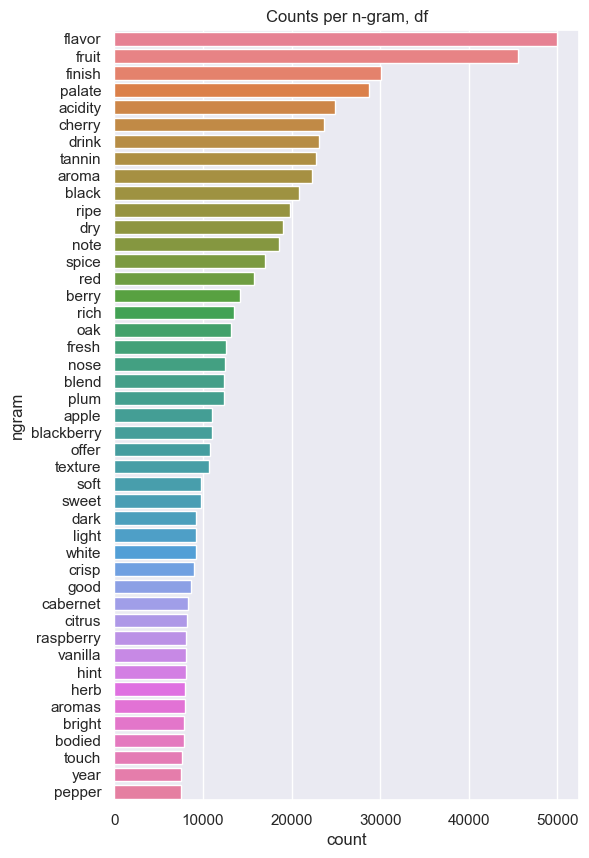

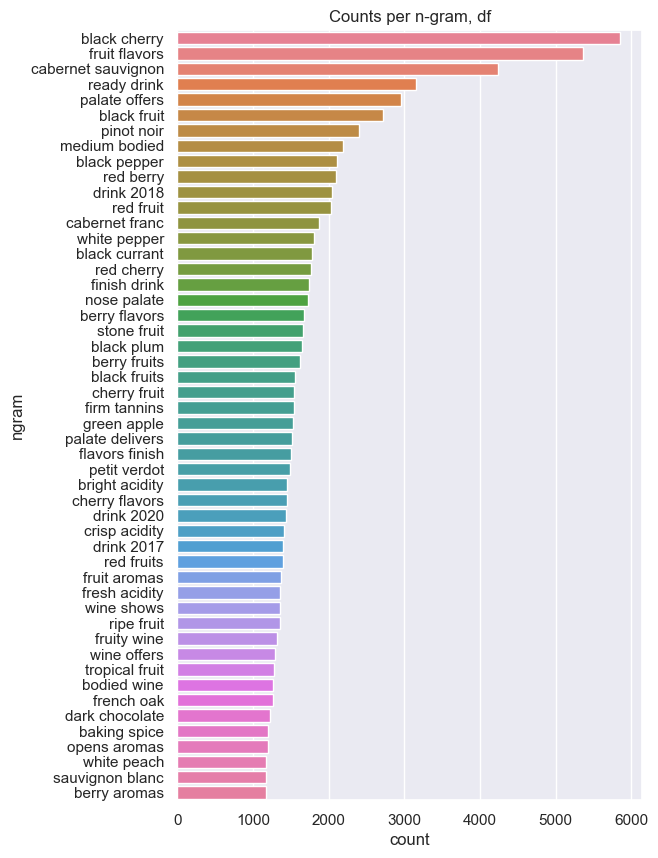

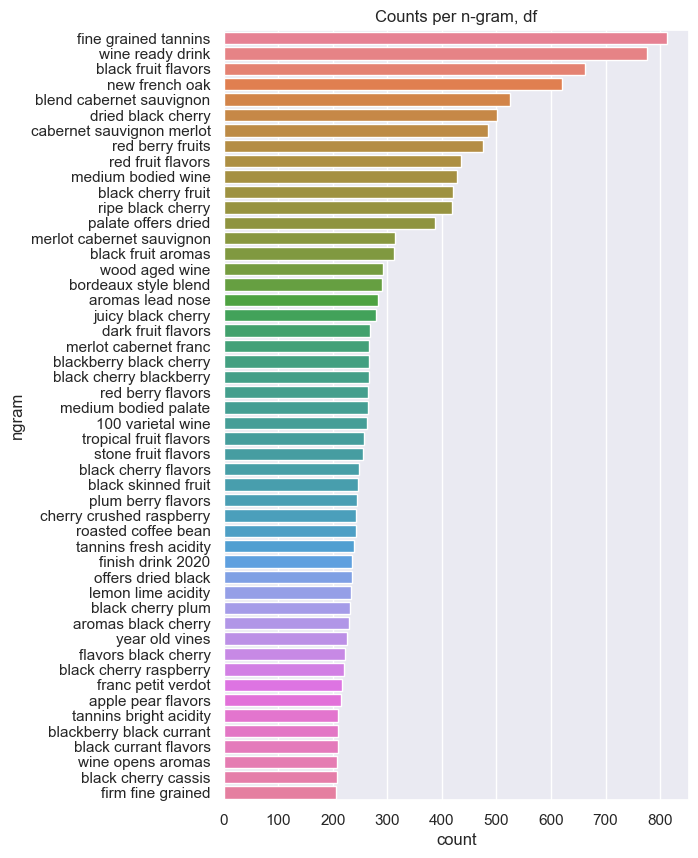

In [51]:
ngram_df_list = [wine_1gram_df, wine_2gram_df, wine_3gram_df]

for df in ngram_df_list:
    bar_chart_top_ngrams(df)
